<a href="https://colab.research.google.com/github/ua-datalab/MLWorkshops/blob/main/GAN_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Notebook by Tom Sercu.

(Updated 2024-04-14, Carlos Lizarraga)

* This jupyter notebook lives in https://github.com/tomsercu/gan-tutorial-pytorch
* [Launch on Google Colab!](https://colab.research.google.com/github/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial.ipynb)
* This tutorial was presented at the [NYC AI & ML meetup](https://www.meetup.com/NYC-Artificial-Intelligence-Machine-Learning/events/260064765/) on April 23d 2019.

# Preliminaries


We have the ambitious goal for this tutorial to be an introduction to both
* Generative Adversarial Networks (GANs) and
* deep learning with pytorch

Since GANs are a more advanced topic in deep learning, we will introduce the deep learning concepts at an intuitive level in function of GANs, and focus on how they're implemented in pytorch.
We will translate GAN / deep learning concepts in code as soon as possible.
In the code we try to strip away complexity and abstractions, to make it easier to absorb the concepts.
The resulting code is minimalistic and very explicit, designed for learning, *not* for running real experiments.

Here is what you will learn:
* GANs are generative models that learn to generate data, based on a min-max/adversarial game between a Generator (G) and Discriminator (D).
* The parameters of both Generator and Discriminator are optimized with Stochastic Gradient Descent (SGD), for which the gradients of a loss function with respect to the neural network parameters are easily computed with pytorch's autograd. This is at the core of deep learning.
* How these concepts translate into pytorch code for GAN optimization.

Overview of the tutorial:
1. GAN intro
2. Defining the neural networks in pytorch, computing a forward pass
3. Optimization with SGD - linear regression example
4. Training our GAN

# Some cool demos:
* Progress over the last 5 years, from [Ian Goodfellow tweet](https://twitter.com/goodfellow_ian/status/1084973596236144640)

![tweet image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/goodfellow_tweet.jpg?raw=1)

* CycleGAN translating horses into zebras: https://www.youtube.com/watch?v=9reHvktowLY
* CycleGAN teaser: ![cyclegan teaser image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/cyclegan_teaser_high_res.jpg?raw=1)
* High resolution faces with StyleGAN https://www.youtube.com/watch?v=kSLJriaOumA
* https://ganbreeder.app web-interface to create images based on [BigGan](https://arxiv.org/abs/1809.11096)


# 1. GAN first introduction
[GAN picture](figs/gan_xavigiro.png)

<img src="https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/gan_xavigiro.png?raw=1" alt="GAN picture" style="width: 700px;"/>

GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data.
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

Let's start with defining the generator G and discriminator D in pytorch.

# 2. Define the neural networks in pytorch

In [ ]:
# if running on colab, pytorch is already installed.
# if running locally, conda or pip install this in your conda environment:
# conda install pytorch torchvision -c pytorch
# OR
# pip3 install torch torchvision
# I'll be assuming python >=3.6 and torch 1.0.1 which currently are the colab defaults.

In [1]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.2.1+cu121


Tested with Python version 3.10.12 and PyTorch version 2.2.1 (2024-04-14)

## torch basics

PyTorch is a package that defines vectors, matrices, or in general "tensors". If you know numpy, you will not be surprised by any of these:

In [2]:
a = torch.ones(3,3)
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [3]:
b = torch.arange(9).float().view(3,3)
b

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [4]:
(a+b)**2

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [5]:
b[:,0]

tensor([0., 3., 6.])

In [6]:
a.zero_() # operations with an underscore modify the Tensor in place.
a

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

You can slice and dice tensors and they have roughly all tensor operations you expect equivalently to numpy, but with a bit more low level control. If you need more intro: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

So what's the big deal about pytorch?

**autograd = automatic differentiation** which allows to compute derivatives of a computation sequence (graph) automatically. More about this later.

## Defining the neural networks

Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator `D`:

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator `G`. `G` takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image
        out = out.view(out.size(0), 1, 28, 28)
        return out


In [9]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


Note that the dimensions of D input and G output were defined for MNIST data.

## Testing the neural networks (forward pass)

In [10]:
# A small batch of 3 samples, all zeros.
samples = torch.randn(5, 1, 28, 28) # batch size x channels x width x height
# This is how to do a forward pass (calls the .forward() function under the hood)
D(samples)

tensor([[0.5404],
        [0.4429],
        [0.5739],
        [0.4279],
        [0.5871]], grad_fn=<SigmoidBackward0>)

Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the weights of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [11]:
for name, p in D.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


We will think of the concatentation of all these discriminator weights in one big vector as $\theta_D$.

Similarly we name the concatentation of all the generator weights in one big vector $\theta_G$.

In [12]:
for name, p in G.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 100])
fc1.bias torch.Size([128])
fc2.weight torch.Size([784, 128])
fc2.bias torch.Size([784])


In [13]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100)
# This is how to do a forward pass (calls the .forward() function under the hood)
x_gen = G(z)
x_gen.shape

torch.Size([2, 1, 28, 28])

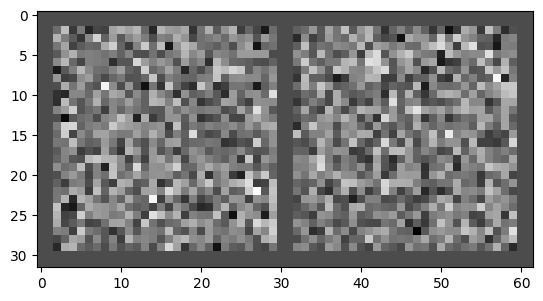

In [14]:
z = torch.randn(2, 100)
show_imgs(G(z))

## Loading the data and computing forward pass

In [15]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9520106.35it/s] 


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175937.97it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3251089.89it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13512063.20it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a sample:

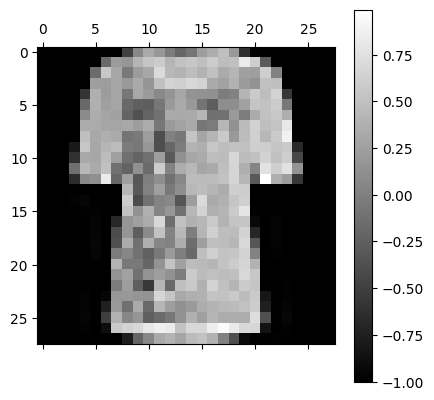

In [16]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [17]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.5608]], grad_fn=<SigmoidBackward0>)

In [19]:
# Error Fix  (2024-03-14)
import torch
from torch.utils.data import DataLoader

print(type(dataloader))


<class 'torch.utils.data.dataloader.DataLoader'>


In [20]:
# How you can get a batch of images from the dataloader:
#xbatch, _ = iter(dataloader).next() # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch, _ = next(iter(dataloader))
xbatch.shape
D(xbatch) # 64x1 tensor: 64 predictions of probability of input being real.
D(xbatch).shape

torch.Size([64, 1])

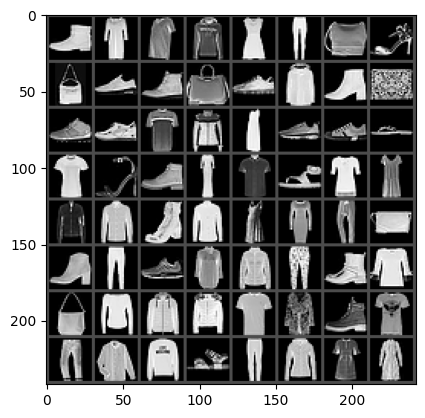

In [21]:
show_imgs(xbatch)

# 3 Intermezzo: optimization with SGD - linear regression example

We will step away from GANs for a second to introduce the core of deep learning: optimization with SGD.

Here are the core components of a basic deep learning classifier/regression setup:
* a neural network $\hat{y}=f(x, \theta)$, which takes an input $x$ and parameters $\theta$, and outputs $\hat{y}$, a prediction of label $y$.
* a loss function $\mathcal{L}(\theta) = \mathbb{E}_{x,y \sim p_d} \ell(f(x, \theta), y) \approx \sum_{x_i,y_i \sim mb} \ell(f(x_i, \theta), y_i)$.
* optimizing $\theta$ to reduce the loss, by making small updates to $\theta$ in the direction of $-\nabla_\theta \mathcal{L}(\theta)$.

pytorch is designed around these core components:
* The way to define a neural network is with `torch.nn.Module`, see how we defined the Discriminator and Generator above.
    - a `Module` defines (1) its weights and (2) defines the operations done with them.
    - initializing a module initializes the weights at random
* $\theta$ stands for all our neural network weights (everything you get from `.parameters()`)
* In the optimization loop you will evaluate a "minibatch" of samples (in our case 64) to compute the neural network output, and the loss measuring how far away those predictions are from the truth.
* To compute the gradient $\nabla_\theta \mathcal{L}(\theta)$, you call `.backward()` on the loss. This is where the magic happens: the gradient wrt all weights in the neural network is computed. They appear in a new Tensor `p.grad` for each `p in net.parameters()`
    - under the hood, this happens by keeping track of the computational graph, and reversing the computation order to "backpropagate" the loss with the chain rule.
    - [Figure which shows a bit more detail](https://tom.sercu.me/assets/201812CCNY/NN_fig.pdf)

A side note about optimization:
- optimization through small consecutive steps along the gradient $-\nabla_\theta \mathcal{L}(\theta)$ is called gradient descent, the stochastic version is stochastic gradient descent (SGD).
- (S)GD is probably the simplest optimization algorithm, you can do much more complex things like combining gradients along multiple timesteps, take curvature information into account, etc.
- in deep learning, SGD and (adaptive learning rate) variations like Adam are the workhorse.
- [This distill.pub article](https://distill.pub/2017/momentum/) has nice visualizations and analysis of SGD with momentum.

### 3a: basic autograd example

So we said the big deal about pytorch (or other deep learning package) is **autograd = automatic differentiation** which allows to compute derivatives automatically.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [22]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[ 1.3935,  0.7482],
        [-1.5363, -1.5556]], requires_grad=True)

In [23]:
# no gradient yet at this point:
print(x.grad)

None


In [24]:
y=(x**2 + x)
z = y.sum()
z

tensor(6.3319, grad_fn=<SumBackward0>)

We know from high school math that the derivative `dz / dx[i,j]` = 2*x[i,j] +1

In [25]:
z.backward()
x.grad

tensor([[ 3.7871,  2.4964],
        [-2.0727, -2.1112]])

In [26]:
2*x+1

tensor([[ 3.7871,  2.4964],
        [-2.0727, -2.1112]], grad_fn=<AddBackward0>)

You can play with this: you can introduce any tensor operation here; for example `torch.exp(torch.sin(x**2))`. Confirm that the gradient matches the analytical derivative.

More about autograd in the tutorial https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py and the docs https://pytorch.org/docs/stable/autograd.html


This was a very basic example of what pytorch autograd does for us: computing the derivatives of a scalar function $z(x)$ wrt $x$: $\nabla_x z(x)$.
In a deep learning context this will be at the basis of our optimization; now we will have
* $\mathcal{L}(\theta)$  the loss is a (scalar) function of neural network parameters (vector) $\theta$.
* autograd will allow us to call `.backward()` on the loss, which will compute the gradient of the loss with respect to neural network parameters $\nabla_\theta \mathcal{L}(\theta)$.
* For each of the parameters `p` the gradient will be in `p.grad`
* Can you confirm that for the parameters of G/D, the flag `.requires_grad` is `True`?

In [27]:
for p in G.parameters():
    print(p.grad)

None
None
None
None


### 3b: Linear regression

Let's try this for a simple linear mapping `y = f(x, theta) = <x, theta>` with $x, \theta \in \mathbb{R}^{2}$. We we want to optimize $\theta$:

In [28]:
torch.manual_seed(23231)
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor ([3, 6, 9, -9, -6]).view(5,1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1) # 5 x 2 input. 5 datapoints, 2 dimensions.
# theta = torch.randn(1,2, requires_grad=True) # ~equal to:
theta = torch.nn.Parameter(torch.randn(1,2))
# we start theta at random initialization, the gradient will point us in the right direction.
print('x:\n', x)
print('y:\n', y)
print('theta at random initialization: ', theta)
thetatrace = [theta.data.clone()] # initial value, for logging

x:
 tensor([[ 1.0000, -1.0593],
        [ 2.0000,  1.2427],
        [ 3.0000, -0.5301],
        [-3.0000, -0.8405],
        [-2.0000, -1.6378]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  Parameter containing:
tensor([[ 0.4849, -0.3917]], requires_grad=True)


Take a look at x and y. What is their correct (linear) relationship?

A: `y = 3 x1 + 0 x2`

Now we define a prediction as a linear mapping $\hat{y} = (X . \theta)$

We will compute the ordinary least squares objective (mean squared error):  $\mathcal{L}(\theta) = (\hat{y}(x,\theta) - y)^2$

Compute $\nabla_\theta \mathcal{L}(\theta)$, and

Move $\theta$ a small step opposite to that direction

In [29]:
ypred = x @ theta.t() # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print('ypred:\n', ypred)
loss = ((ypred-y)**2).mean() # mean squared error = MSE
print('mse loss: ', loss.item())
loss.backward()
print('dL / d theta:\n', theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print('theta:\n', theta)
thetatrace.append(theta.data.clone()) # for logging

ypred:
 tensor([[ 0.8998],
        [ 0.4830],
        [ 1.6623],
        [-1.1254],
        [-0.3282]], grad_fn=<MmBackward0>)
mse loss:  36.57358169555664
dL / d theta:
 tensor([[-28.0458,  -6.6600]])
theta:
 Parameter containing:
tensor([[3.2895, 0.2743]], requires_grad=True)


You can re-execute this cell above a couple of times and see how $\theta$ goes close towards the optimal value of `[3,0]`.

Text(0, 0.5, 'theta[1]')

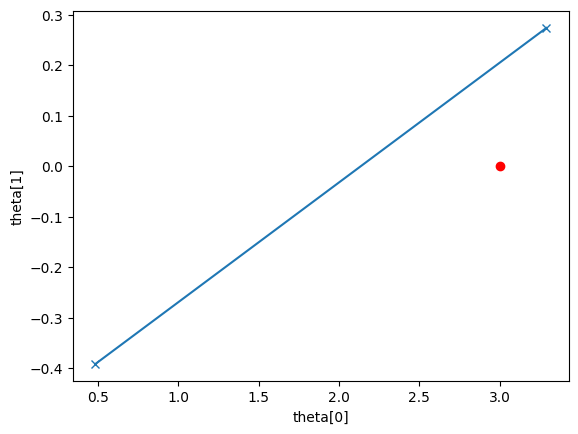

In [30]:
# Now let us plot in 2D what happened to theta during SGD optimization. In red is the true relation.
thetas = torch.cat(thetatrace, dim=0).numpy()
plt.figure()
plt.plot(thetas[:,0], thetas[:, 1], 'x-')
plt.plot(3, 0, 'ro')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')

Ok, doing this manually gives you insight what happens down to the details. But usually we do not do the gradient updates manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us abstractions to easily manage this complexity:
* `nn.Linear()` (or generally  `Module`s) which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
* `module.zero_grad()` to clear the gradients,
* `optim.SGD` with which you can do `optimizer.step()` to do a step of SGD.

In [31]:
torch.manual_seed(23801)
net = nn.Linear(2,1, bias=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100): # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred-y)**2).mean() # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[3.0000e+00, 1.0507e-07]], requires_grad=True)


Indeed this is very close to the optimal $\theta=[3,0]$.

# 4. Back to GANs: The min-max game.

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.



In [32]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [33]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [36]:
# STEP 1: Discriminator optimization step
#x_real, _ = iter(dataloader).next()
x_real, _ = next(iter(dataloader))
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

#print(D_x.mean().item(), D_G_z.mean().item())

0.5598723888397217 0.4918198585510254


Some things to think about / try out / investigate:
* what are the mean probabilities for real and fake? print them and see how they change when executing the cell above a couple of times. Does this correspond to your expectation?
* can you confirm how the use of the criterion maps to the objective stated above?
* when calling backward, the derivative of the loss wrt **what** gets computed?
* what does `.detach()` do? Are the Generator parameters' gradients computed?

In [37]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.4889960289001465


Again run this cell a couple of times. See how the generator increases its Discriminator score?

Some more things to ponder:
* Do the Generator parameters now receive gradients? Why (compared to previous loop)?
* From the definition of BCE loss confirm that this comes down to $-\log D(G(z))$

### Putting it all together: the full training loop

Modifications to the code:
* add device parameter to take GPU if available
* use [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) (an adaptive learning-rate variation of SGD with momentum)
* some very minimal logging

Device:  cuda
e0.i0/938 last mb D(x)=0.4225 D(G(z))=0.5026
e0.i100/938 last mb D(x)=0.9418 D(G(z))=0.3590
e0.i200/938 last mb D(x)=0.9216 D(G(z))=0.1803
e0.i300/938 last mb D(x)=0.9297 D(G(z))=0.1209
e0.i400/938 last mb D(x)=0.9647 D(G(z))=0.0237
e0.i500/938 last mb D(x)=0.9494 D(G(z))=0.0503
e0.i600/938 last mb D(x)=0.8246 D(G(z))=0.2550
e0.i700/938 last mb D(x)=0.8111 D(G(z))=0.2446
e0.i800/938 last mb D(x)=0.6109 D(G(z))=0.3285
e0.i900/938 last mb D(x)=0.9042 D(G(z))=0.1431
e1.i0/938 last mb D(x)=0.6727 D(G(z))=0.3580
e1.i100/938 last mb D(x)=0.8999 D(G(z))=0.0809
e1.i200/938 last mb D(x)=0.7370 D(G(z))=0.3656
e1.i300/938 last mb D(x)=0.6667 D(G(z))=0.3538
e1.i400/938 last mb D(x)=0.9500 D(G(z))=0.0429
e1.i500/938 last mb D(x)=0.5995 D(G(z))=0.4389
e1.i600/938 last mb D(x)=0.2378 D(G(z))=0.2876
e1.i700/938 last mb D(x)=0.9531 D(G(z))=0.0413
e1.i800/938 last mb D(x)=0.9376 D(G(z))=0.0665
e1.i900/938 last mb D(x)=0.5693 D(G(z))=0.3709
e2.i0/938 last mb D(x)=0.6940 D(G(z))=0.3538
e2.i1

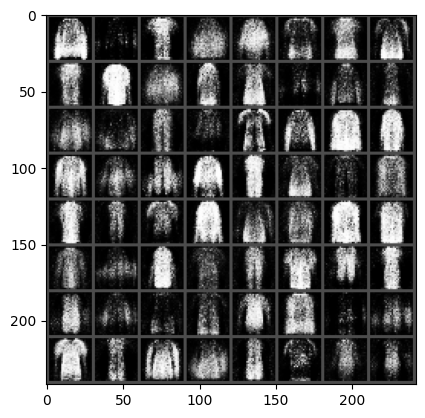

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(3): # 10 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        #x_real, _ = iter(dataloader).next()
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

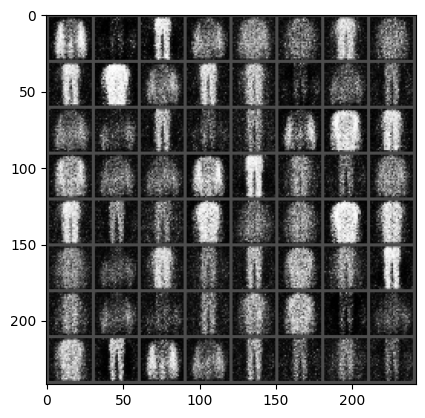

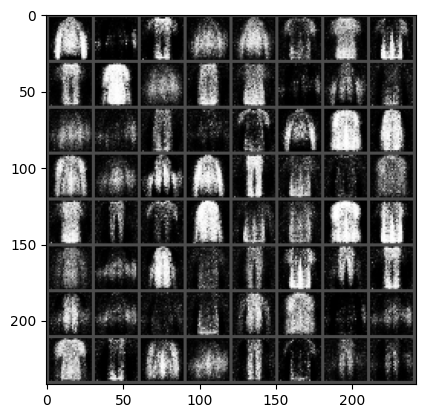

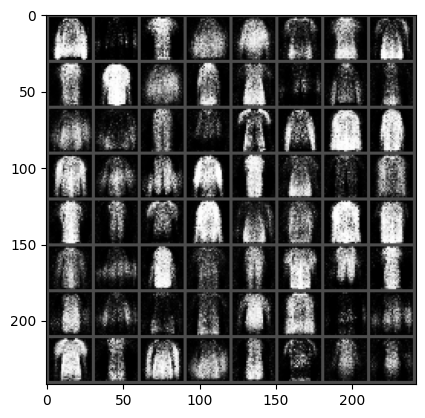

In [40]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

# A demo of a state of the art GAN and "painting" with them in your browser:

https://gandissect.csail.mit.edu

By our colleagues at the MIT-IBM Watson AI Lab.


# Where to go from here
* Improvements to make on the current training loop: use `optim.Adam` instead of SGD, define bigger networks, add logging (check out tensorboardX) and monitor losses.
* Use a more exciting datasets - check out [the pytorch torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) to get started quickly.
* The [original GAN paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets)
* The [DCGAN paper](https://arxiv.org/abs/1511.06434) which made it all work much better for images. Start from: pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* Newer generations of loss functions measure different distances between distributions $p_{data}$ and $p_G$. For example [WGAN](https://github.com/martinarjovsky/WassersteinGAN), [WGAN-GP](https://arxiv.org/abs/1704.00028), [Fisher GAN](https://arxiv.org/abs/1705.09675), [Sobolev GAN](https://arxiv.org/abs/1711.04894), many more. They often have better stability properties wrt the original GAN loss.

# References for this tutorial
* pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich
* [Medium blog post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) by Diego Gomez Mosquera
* [Material made for ITDS course at CUNY](https://github.com/grantmlong/itds2019/blob/master/lecture-6/DL_lab_solutions.ipynb) by Tom Sercu (that's me!)
* [Blog post](https://towardsdatascience.com/graduating-in-gans-going-from-understanding-generative-adversarial-networks-to-running-your-own-39804c283399) by Cecelia Shao
* [GAN overview image](https://www.slideshare.net/xavigiro/deep-learning-for-computer-vision-generative-models-and-adversarial-training-upc-2016) from Xavier Giro